In [ ]:
import pandas as pd
import numpy as np
import glob
import os

# Define the folder containing the CSV files
folder_path = "/Users/oscarxue/Downloads/SPXdata2/"

# Get all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Initialize an empty list to store DataFrames
df_list = []

# Process each CSV file
for file in csv_files:
    # Extract expiration date from the filename 
    try:
        filename = os.path.basename(file)
        date_part = filename.split("-exp-")[1].split("-weekly")[0].split("-monthly")[0]  # Extract date
        maturity_date = date_part.strip()  # Clean up the extracted date
    except IndexError:
        print(f"Could not extract date from filename: {filename}")
        continue

    # Read the CSV file
    df = pd.read_csv(file)

    # Add a "Maturity" column with the extracted expiration date
    df["Maturity"] = maturity_date

    # Append to the list
    df_list.append(df)

# Combine all DataFrames into one
merged_df = pd.concat(df_list, ignore_index=True)
merged_df = merged_df.sort_values(by=["Maturity", "Strike"])
merged_df['Maturity'] = pd.to_datetime(merged_df['Maturity'], errors='coerce')

# Reference date
reference_date = pd.to_datetime("2025-03-06")
# Calculate time to expiration in years
merged_df['Maturity'] = (merged_df['Maturity'] - reference_date).dt.days / 365
# Remove rows where "Strike" contains the unwanted string
merged_df = merged_df[~merged_df["Strike"].str.contains('Downloaded from Barchart.com', na=False)]

# For 'Strike' column: Replace comma only if present
for col in ['Bid', 'Mid', 'Ask', 'Strike']:
    merged_df[col] = (
        merged_df[col]
        .astype(str)              # Ensure all entries are treated as strings
        .str.replace(',', '')     # Remove commas
        .astype(float)            # Convert to float
    )

merged_df['Type'] = merged_df['Type'].replace({'Call': 'call', 'Put': 'put'})
merged_df

,Strike,Moneyness,Bid,Mid,Ask,Last,Change,%Chg,Volume,Open Int,OI Chg,Delta,IV,Type,Last Trade,Maturity
0,5520.0,+4.92%,273.50,274.90,276.30,248.81,unch,unch,0,2,unch,0.98111,44.80%,call,03/05/25,0.002740
100,5520.0,-4.92%,0.85,0.90,0.95,1.37,+1.02,+291.43%,467,847,+210,-0.01823,44.48%,put,11:55 ET,0.002740
1,5525.0,+4.83%,268.50,269.95,271.40,414.47,unch,unch,0,0,unch,0.98009,44.43%,call,03/03/25,0.002740
101,5525.0,-4.83%,0.90,0.95,1.00,1.4,+0.95,+211.11%,361,937,+155,-0.02002,44.47%,put,11:54 ET,0.002740
2,5530.0,+4.75%,263.30,264.85,266.40,276.04,unch,unch,0,10,+4,0.98136,43.01%,call,03/05/25,0.002740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8427,6950.0,+19.74%,974.60,983.60,992.60,0.00,unch,unch,0,0,unch,0.00000,0.00%,put,NaN,0.865753
8328,6975.0,-20.17%,25.70,26.15,26.60,37.00,unch,unch,0,89,unch,0.09275,11.74%,call,03/03/25,0.865753
8428,6975.0,+20.17%,996.50,1005.55,1014.60,785.51,unch,unch,0,1,unch,0.00000,0.00%,put,01/17/25,0.865753
8329,7000.0,-20.60%,23.70,24.15,24.60,24.70,-3.00,-10.83%,4,"3,362",+2,0.08690,11.71%,call,11:29 ET,0.865753


In [13]:
# Separate calls
calls_df = merged_df[merged_df['Type'] == 'call'][['Strike', 'Maturity', 'Mid']]
calls_df = calls_df.rename(columns={'Strike': 'strike', 'Maturity': 'maturity', 'Mid': 'mid'})
Kc = calls_df['strike']
Tc = calls_df['maturity']
C0 = calls_df['mid']

# Separate puts
puts_df = merged_df[merged_df['Type'] == 'put'][['Strike', 'Maturity', 'Mid']]
puts_df = puts_df.rename(columns={'Strike': 'strike', 'Maturity': 'maturity', 'Mid': 'mid'})
Kp = puts_df['strike']
Tp = puts_df['maturity']
P0 = puts_df['mid']


In [ ]:
import numpy as np
import pandas as pd
from scipy.interpolate import PchipInterpolator  # Changed import
import matplotlib.pyplot as plt

# Get unique maturities and spot price
T_vectU = np.sort(merged_df['Maturity'].unique())
S0 = 5805 #5767 
npt = 10000  # Number of grid points
m = 0.05      # Range multiplier
nCol = 5
nRow = int(np.ceil(len(T_vectU)/nCol))
iFwd = []
plt.figure(figsize=(20, 5*nRow))

# Initialize results storage
results = {}

# Initialize storage objects BEFORE the loop
xMatch = {T: np.nan for T in T_vectU}
iFwd = []    # List to collect implied forwards

for idx, T in enumerate(T_vectU):
    # Filter maturity data
    calls_T = calls_df[calls_df['maturity'] == T].sort_values('strike')
    puts_T = puts_df[puts_df['maturity'] == T].sort_values('strike')
        
    # Calculate bounds and grid
    minVal = S0 * np.exp(-m * T)
    maxVal = S0 * np.exp(m * T)
    numPoints = int(maxVal - minVal) * npt
    x = np.linspace(minVal, maxVal, numPoints)
        
    # Create interpolators
    call_interp = PchipInterpolator(calls_T['strike'].values, calls_T['mid'].values)
    put_interp = PchipInterpolator(puts_T['strike'].values, puts_T['mid'].values)
    
    # Store results
    C0a = call_interp(x)
    P0a = put_interp(x)
    
    results[T] = {
        'grid': x,
        'calls_interp': C0a,
        'puts_interp': P0a,
        'raw_calls': calls_T,
        'raw_puts': puts_T,
        'bounds': (minVal, maxVal)
    }

    # Find minimum absolute difference
    priceDifference = np.abs(P0a - C0a)
        
    # Find minimum difference location
    minDiff = np.min(priceDifference)
    indexOfMinDiff = np.argmin(priceDifference)
            
    # Get corresponding x value
    xMatch[T] = x[indexOfMinDiff]
    # Get all strikes for current maturity
    current_strikes = np.concatenate([
            calls_T['strike'].values,
            puts_T['strike'].values
    ])
    
    # Append to iFwd vector
    iFwd.extend([xMatch[T]] * len(current_strikes))
        

    
# Convert to numpy arrays
xMatch_array = np.array(list(xMatch.values()))
iFwd_array = np.array(iFwd)
merged_df['Implied Forward'] = iFwd_array


<Figure size 2000x4500 with 0 Axes>

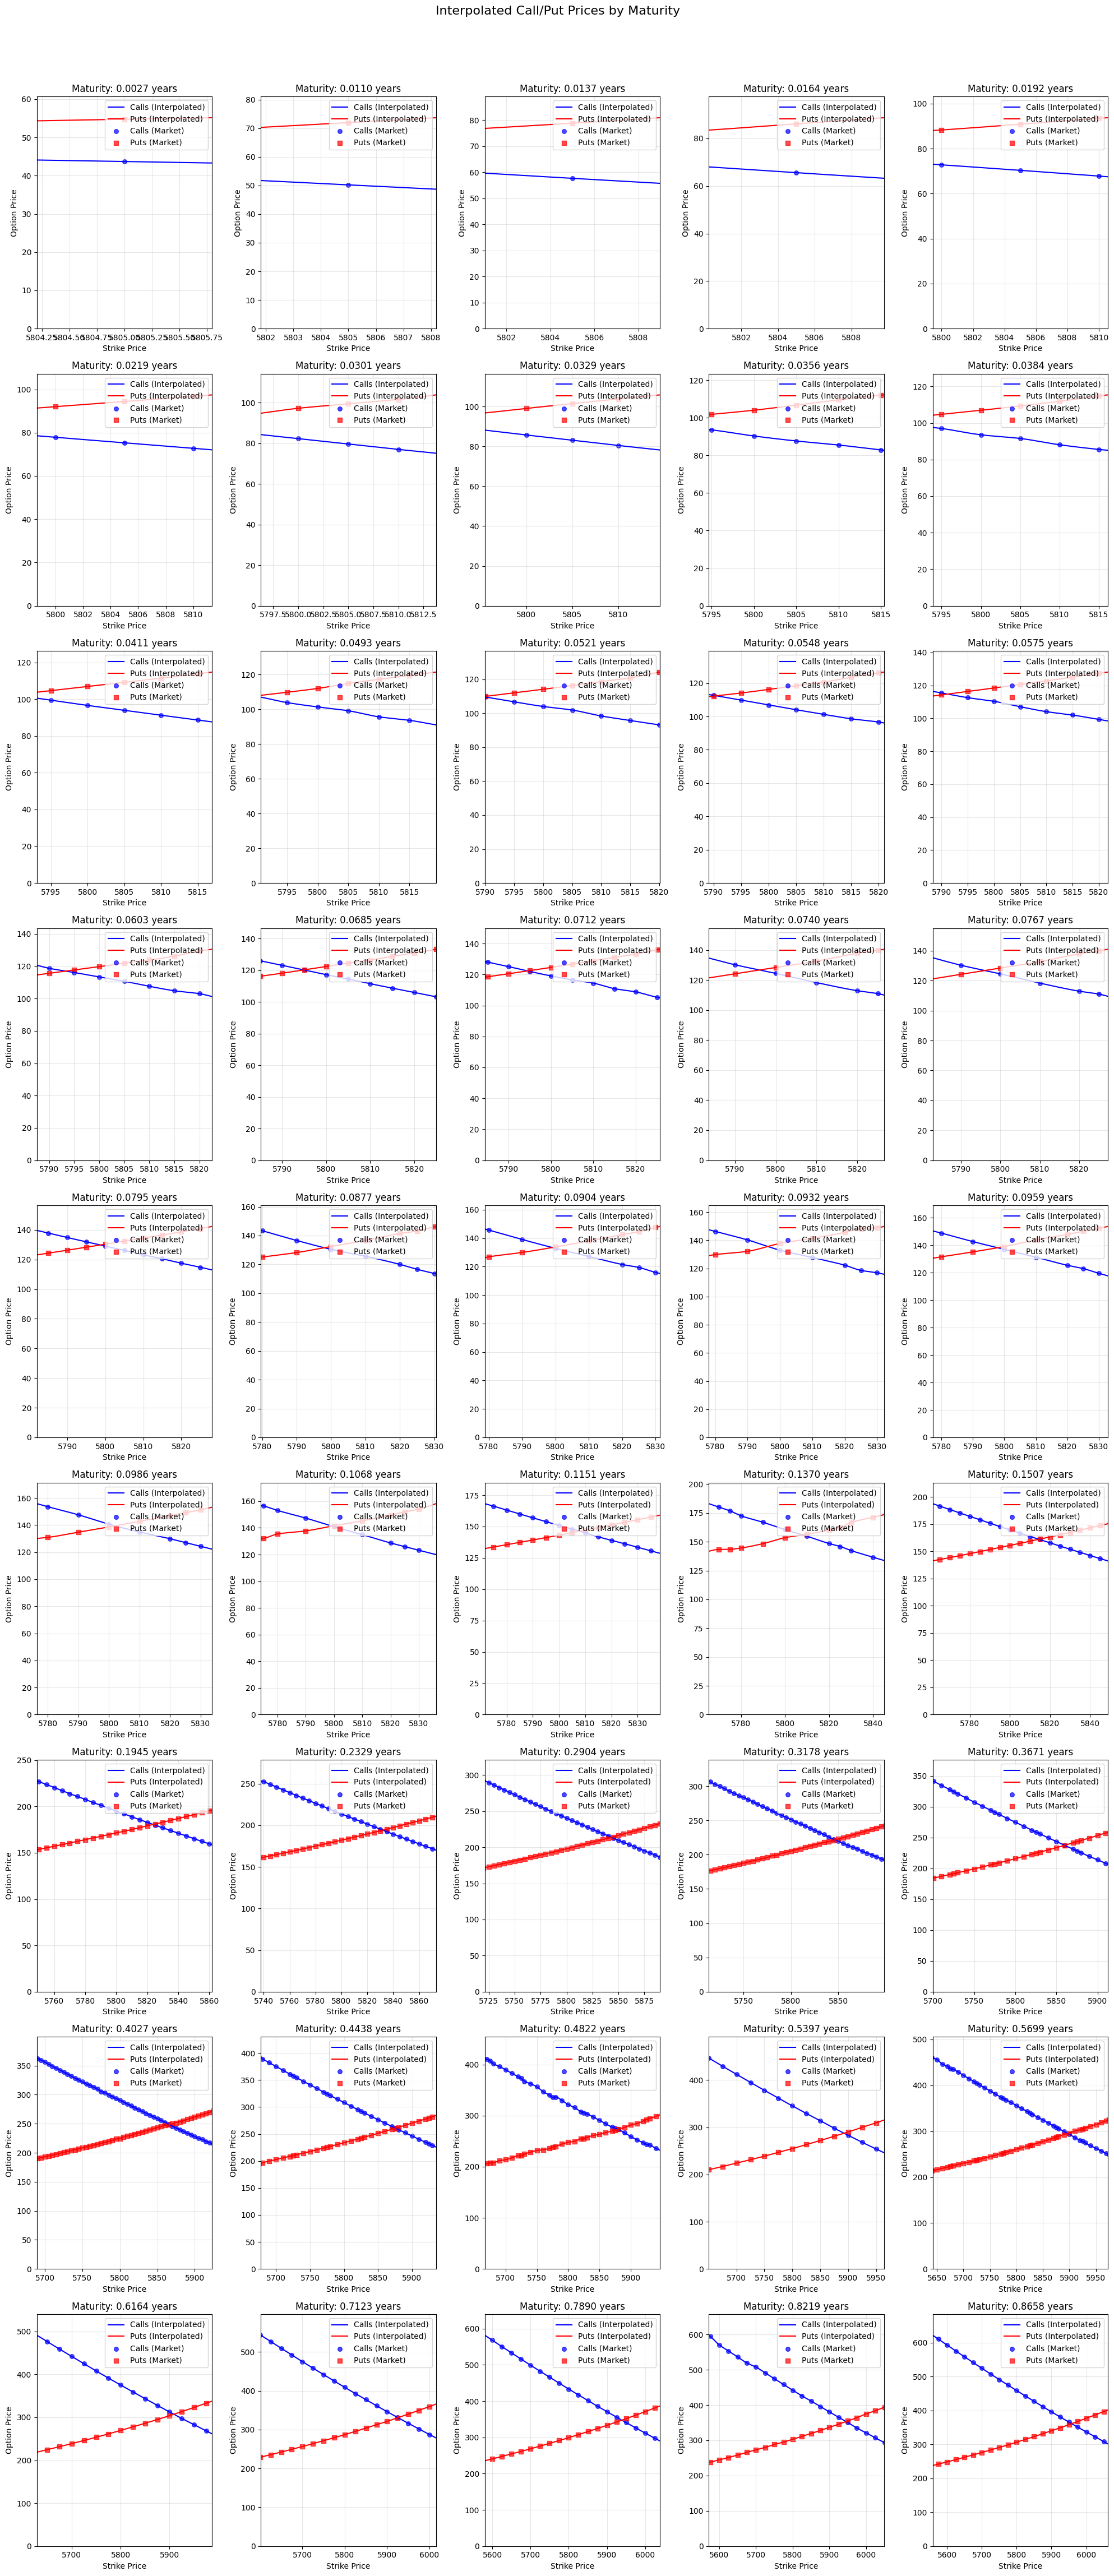

In [52]:
# Create figure with subplot grid
plt.figure(figsize=(20, 5*nRow))
plt.suptitle("Interpolated Call/Put Prices by Maturity", y=1.02, fontsize=16)

for idx, T in enumerate(T_vectU):
    # Get results for current maturity
    res = results[T]
    x = res['grid']
    C0a = res['calls_interp']
    P0a = res['puts_interp']
    raw_calls = res['raw_calls']
    raw_puts = res['raw_puts']
    
    # Create subplot
    ax = plt.subplot(nRow, nCol, idx+1)
    
    # Plot interpolated prices
    ax.plot(x, C0a, 'b-', label='Calls (Interpolated)', linewidth=1.5)
    ax.plot(x, P0a, 'r-', label='Puts (Interpolated)', linewidth=1.5)
    
    # Plot raw market prices
    ax.scatter(raw_calls['strike'], raw_calls['mid'], 
               c='blue', s=30, marker='o', label='Calls (Market)', alpha=0.7)
    ax.scatter(raw_puts['strike'], raw_puts['mid'], 
               c='red', s=30, marker='s', label='Puts (Market)', alpha=0.7)
    
    
    # Formatting
    ax.set_title(f"Maturity: {T:.4f} years")
    ax.set_xlabel("Strike Price")
    ax.set_ylabel("Option Price")
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')
    
    # Set sensible axis limits
    ax.set_xlim(res['bounds'][0], res['bounds'][1])
    ax.set_ylim(0, max(np.nanmax(C0a), np.nanmax(P0a)) * 1.1)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [53]:
#cost of carry and discount factor
interest_rate = np.log(merged_df['Implied Forward'] / S0) / merged_df['Maturity']
merged_df['Interest Rate'] = interest_rate
r_vect = interest_rate.unique()


In [54]:
import py_vollib.black.implied_volatility
import py_vollib_vectorized

merged_df['Type'] = merged_df['Type'].replace({'call': 'c', 'put': 'p'})
iv = py_vollib_vectorized.vectorized_implied_volatility_black(merged_df['Mid'], merged_df['Implied Forward'], merged_df['Strike'], merged_df['Interest Rate'], merged_df['Maturity'],flag=merged_df['Type'], return_as='numpy')
merged_df['Calculated Implied Vol'] = iv


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/py_vollib_vectorized/implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 400, 402, 404, 406, 408, 410, 412, 414, 416, 418, 420, 422, 424, 426, 428, 430, 432, 434, 436, 600, 602, 604, 606, 608, 610, 612, 614, 616, 618, 800, 802, 804, 806, 1000, 1002, 1004, 1006, 3600, 3602, 3604, 3606, 3608, 3610, 3612, 3614, 3616, 3618, 3777, 3779, 3781, 3783, 3785, 3787, 3789, 3791, 3793, 3795, 3797, 3798, 3800, 3802, 3804, 3806, 3808, 3810, 3812, 3814, 3816, 3975, 3977, 3979, 3981, 3983, 3985, 3987, 3989, 3991, 3993, 3995, 4196, 4198, 4200, 4202, 4204, 4206, 4208, 4210, 4212, 4214, 4216, 4218, 4367, 4369, 4371, 4373, 4375, 4377, 4379, 4381, 4383, 4385,

In [55]:
iv_puts = merged_df[merged_df['Type'] == 'p'][['Calculated Implied Vol']]
iv_calls = merged_df[merged_df['Type'] == 'c'][['Calculated Implied Vol']]

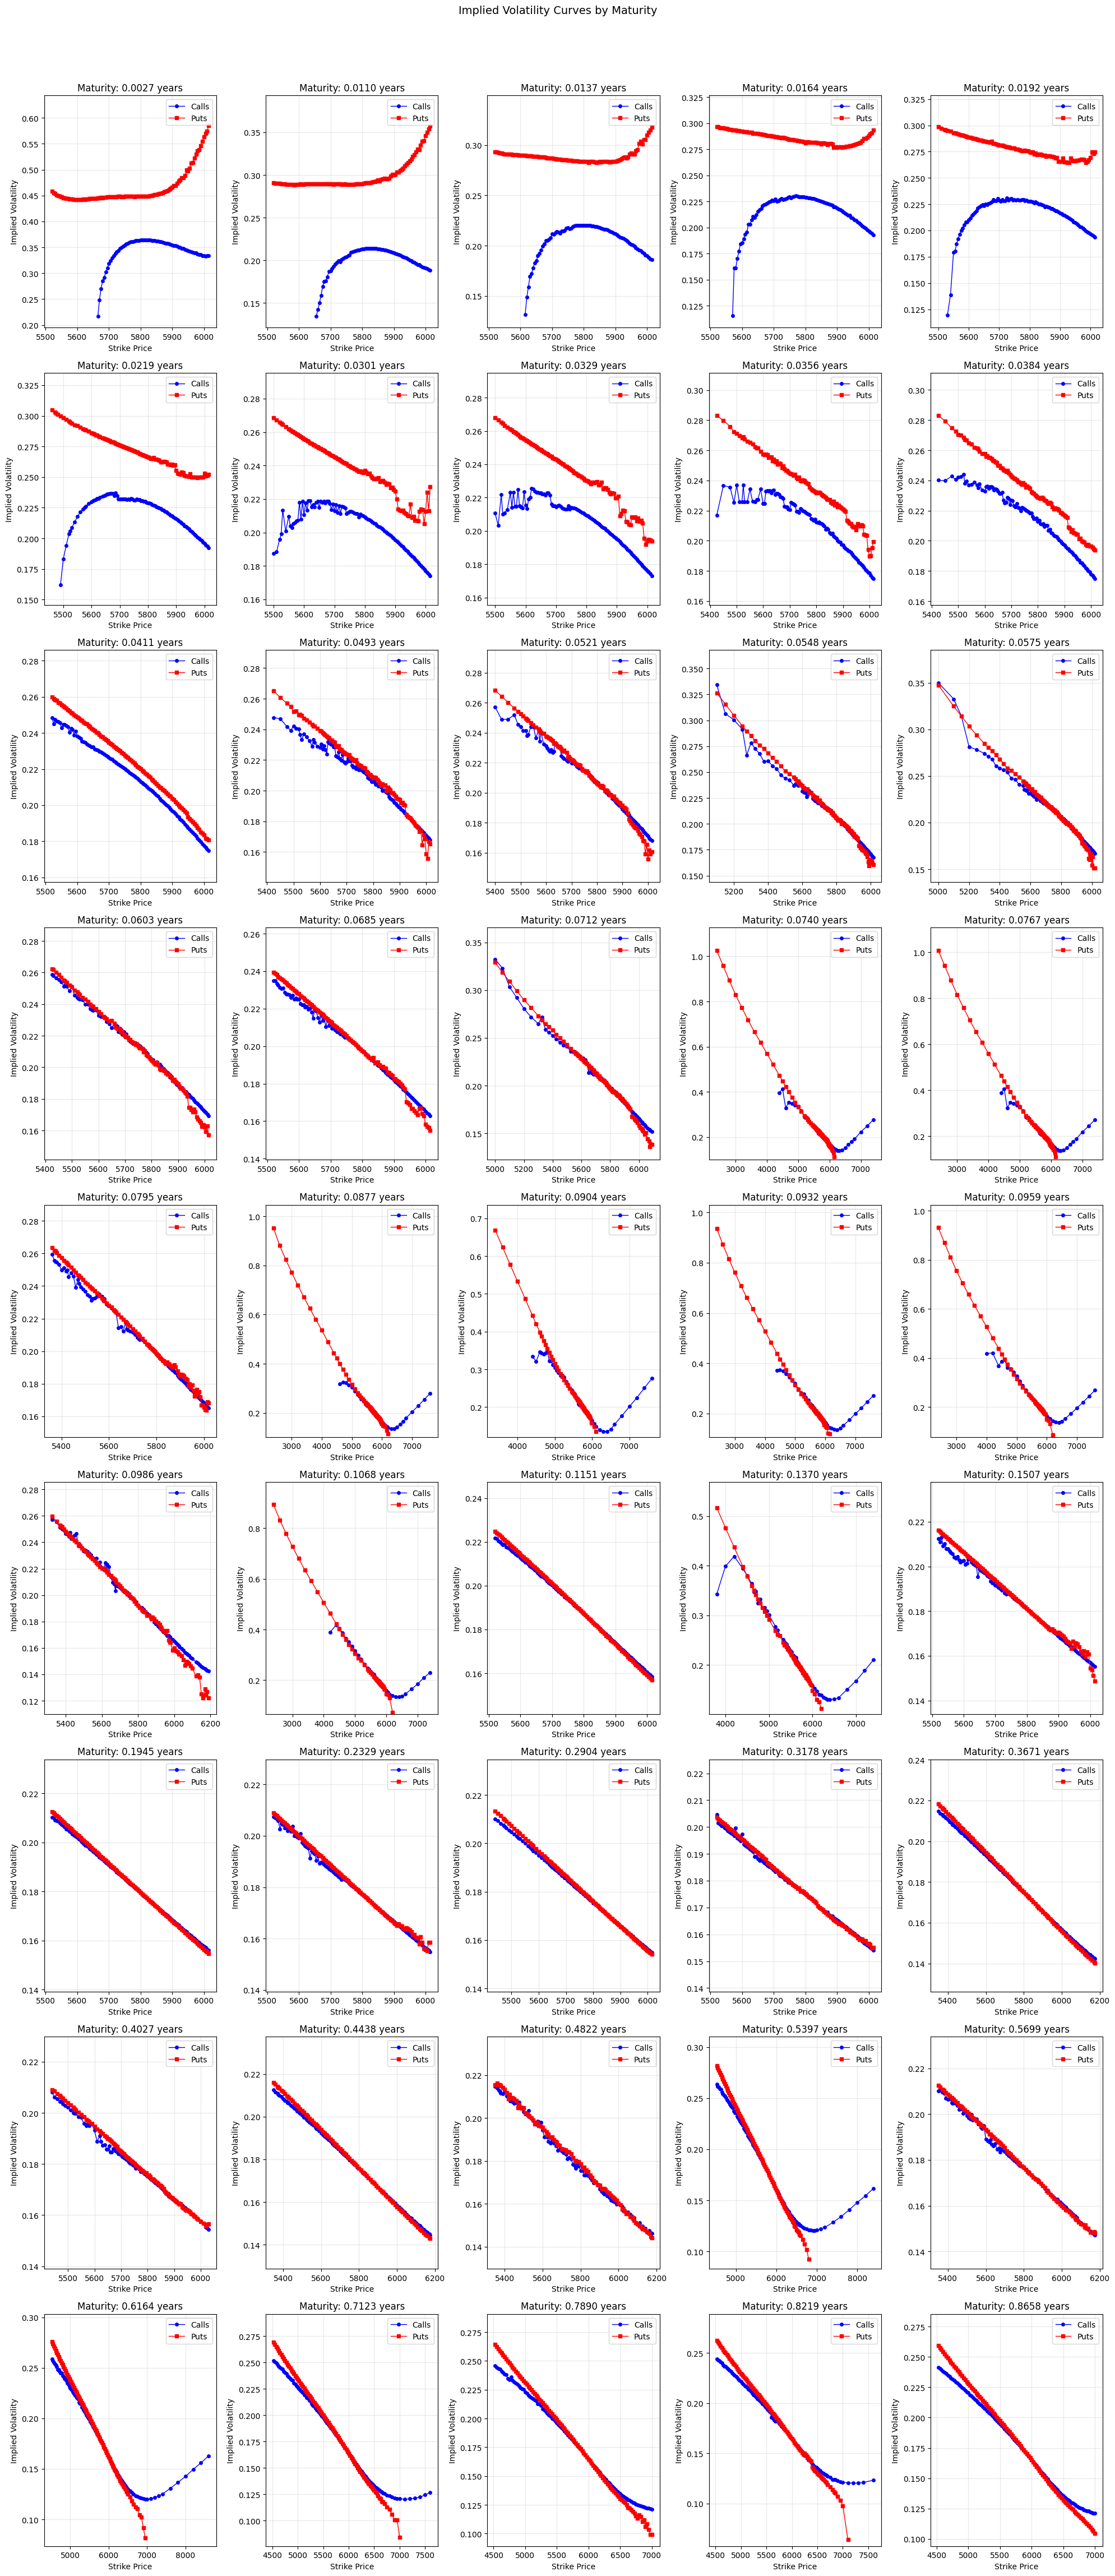

In [56]:
# Create figure with subplot grid
plt.figure(figsize=(20, 5*nRow))
plt.suptitle("Implied Volatility Curves by Maturity", y=1.02, fontsize=14)

for idx, T in enumerate(T_vectU):
    # Filter data for current maturity
    maturity_mask = merged_df['Maturity'] == T
    
    # Get calls and puts for this maturity
    calls = merged_df[(merged_df['Type'] == 'c') & maturity_mask].sort_values('Strike')
    puts = merged_df[(merged_df['Type'] == 'p') & maturity_mask].sort_values('Strike')
    
    # Create subplot
    ax = plt.subplot(nRow, nCol, idx+1)
    
    # Plot call IVs
    ax.plot(calls['Strike'], calls['Calculated Implied Vol'], 
            'b-o', markersize=4, linewidth=1, label='Calls')
    
    # Plot put IVs
    ax.plot(puts['Strike'], puts['Calculated Implied Vol'], 
            'r-s', markersize=4, linewidth=1, label='Puts')
    
    # Formatting
    ax.set_title(f"Maturity: {T:.4f} years")
    ax.set_xlabel("Strike Price")
    ax.set_ylabel("Implied Volatility")
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Set consistent axis limits
    all_iv = pd.concat([calls['Calculated Implied Vol'], puts['Calculated Implied Vol']])
    ax.set_ylim(all_iv.min()*0.9, all_iv.max()*1.1)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [57]:

bid = merged_df['Bid']  # Convert to numpy array if not already
ask = merged_df['Ask']

# Create removal mask
pos_remove = (
    (merged_df['Ask'] <= merged_df['Bid']) 
    | (merged_df['Ask'] < 3/8) 
    | ((merged_df['Strike'] < merged_df['Implied Forward']) & (merged_df['Type'] == 'c'))  # Remove ITM calls
    | ((merged_df['Implied Forward'] <= merged_df['Strike']) & (merged_df['Type'] == 'p'))  # Remove ITM puts
)

# Filter out unwanted data using boolean indexing
ask = ask[~pos_remove]
bid = bid[~pos_remove]
forward = merged_df['Implied Forward'][~pos_remove]
interest_rate = merged_df['Interest Rate'][~pos_remove]
maturity = merged_df['Maturity'][~pos_remove]
strike = merged_df['Strike'][~pos_remove]
CP_vect = merged_df['Type'][~pos_remove]
mid = merged_df['Mid'][~pos_remove]

# Calculate moneyness metrics
log_moneyness = np.log(strike / forward)
moneyness = strike / forward

implied_volatility_bid = py_vollib_vectorized.vectorized_implied_volatility_black(bid, forward, strike, interest_rate, maturity, CP_vect, return_as='numpy')
implied_volatility_ask = py_vollib_vectorized.vectorized_implied_volatility_black(ask, forward, strike, interest_rate, maturity, CP_vect, return_as='numpy')
implied_volatility     = py_vollib_vectorized.vectorized_implied_volatility_black(mid, forward, strike, interest_rate, maturity, CP_vect, return_as='numpy')

In [58]:
Matlab_df = pd.DataFrame({'ask' : ask, 'bid' : bid, 'mid' : mid, 'forward' : forward, 'interest_rate' : interest_rate, 'maturity' : maturity, 'strike' : strike, 'CP_vect' : CP_vect, 'implied_volatility_bid' : implied_volatility_bid, 'implied_volatility_ask' : implied_volatility_ask, 'implied_volatility' : implied_volatility, 'log_moneyness' : log_moneyness, 'moneyness' : moneyness})
Matlab_df.to_excel("Matlab_df.xlsx")

In [62]:
imp_vol = pd.read_csv(r'/Users/oscarxue/Downloads/implied_volatilities.csv')
model_implied_volatility = imp_vol['model_implied_volatility']
model_implied_volatility_ask = imp_vol['model_implied_volatility_ask']
model_implied_volatility_bid = imp_vol['model_implied_volatility_bid']

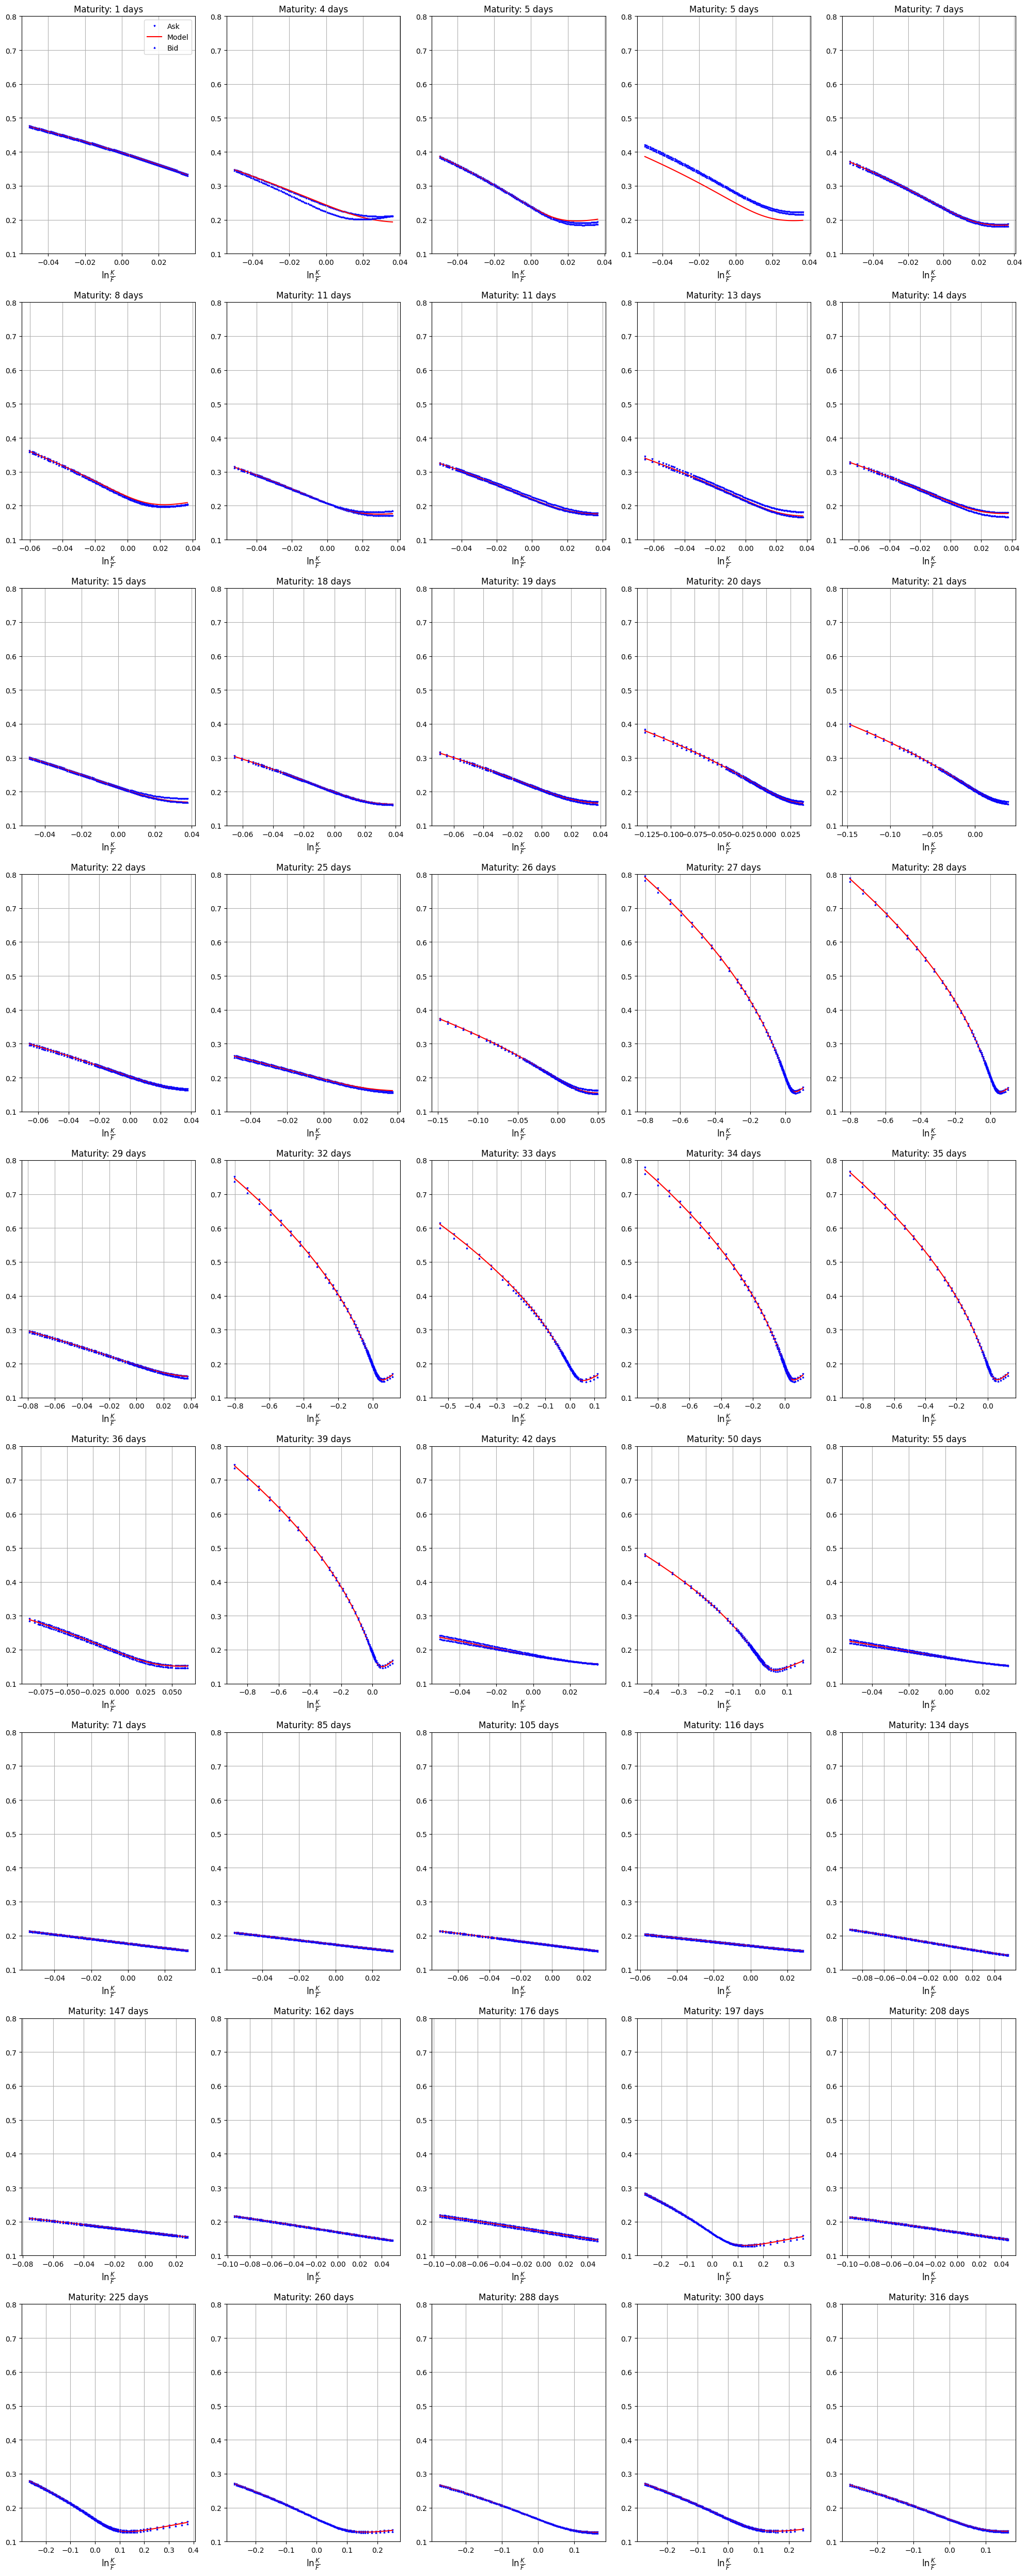

In [63]:
T_vectU_days = (T_vectU * 365).astype(int)
fig, axes = plt.subplots(nRow, nCol, figsize=(20, 50))
axes = axes.flatten()  # Flatten axes array for easy indexing

for t in range(len(T_vectU)):
    pos = (maturity.to_numpy() == T_vectU[t])  # Ensure pos is a NumPy array
    x = np.sort(log_moneyness.to_numpy()[pos])
    idx = np.argsort(log_moneyness.to_numpy()[pos])
    
    IV = model_implied_volatility.to_numpy()[pos][idx]
    IV_a = model_implied_volatility_ask.to_numpy()[pos][idx]
    IV_b = model_implied_volatility_bid.to_numpy()[pos][idx]
    
    ax = axes[t]
    ax.plot(x, IV_a, 'vb', linewidth=1.5, markersize=2, label='Ask')
    ax.plot(x, IV, '-r', linewidth=1.5, label='Model')
    ax.plot(x, IV_b, '^b', linewidth=1.5, markersize=2, label='Bid')
    
    ax.set_title(f'Maturity: {T_vectU_days[t]} days')
    ax.set_ylim([0.1, 0.8])
    ax.set_xlabel(r'$\ln\frac{K}{F}$', fontsize=12)
    ax.grid(True)
    if t == 0:
        ax.legend()
    
fig.tight_layout()
plt.show()

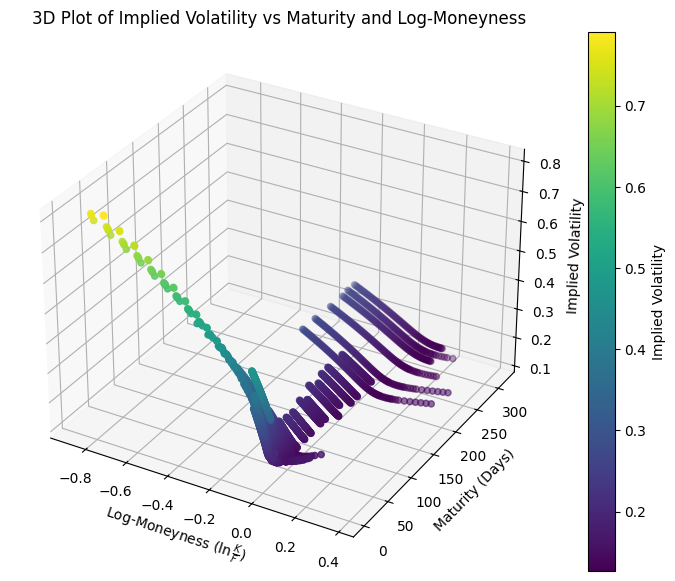

In [64]:
from mpl_toolkits.mplot3d import Axes3D
maturity_days = (maturity.to_numpy() * 365) 
log_moneyness_values = log_moneyness.to_numpy()
implied_vol_values = model_implied_volatility.to_numpy()

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for 3D data
sc = ax.scatter(log_moneyness_values, maturity_days, implied_vol_values, c=implied_vol_values, cmap='viridis')

# Add color bar to indicate implied volatility levels
plt.colorbar(sc, ax=ax, label='Implied Volatility')

# Set labels
ax.set_xlabel(r'Log-Moneyness ($\ln\frac{K}{F}$)')
ax.set_ylabel('Maturity (Days)')
ax.set_zlabel('Implied Volatility')
ax.set_title('3D Plot of Implied Volatility vs Maturity and Log-Moneyness')

plt.show()